# 2021321148 INSIK CHO

In [2]:
# I installed needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
'''
reading graph and label is same with assignment 4
It is suggested to use graphx, But I guess it is same one with week4, i used it.
'''

# set initial df, to be adjacency matrix ,
df = np.zeros((34,34))

# I wrote code to transform adjacency list into adjacency matrix
with open("karate_club.adjlist") as file:
    for _ in range(3):
        next(file)
        
# For every line of file, find pair and give 1 to pair
    for line in file:
        node = list(map(int, line.split()))
        i = node[0]
        for j in node[1:]:
            df[i][j] = 1
            df[j][i] = 1
    file.close()
    
label = np.loadtxt("karate_label.txt")

print('graph data : ' ,df)
print('label :', label[:5])

graph data :  [[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
label : [[0. 1.]
 [1. 1.]
 [2. 1.]
 [3. 1.]
 [4. 1.]]


### Random Walks

In [9]:
def randomwalks(G,root,t=10):
    walks = [root]
    
    for _ in range(t-1):
        # the root node of each randomwalk iteration.
        root_node = G[:,root]
        # connected nodes
        connect = []
        
        # iteration to get neighbor
        # used enumerate, for each cell being 1, save its label 
        for index, connection in enumerate(root_node):
            if connection ==1:
                connect.append(index)
                
        # set one of connected node as 'next', 
        # to start over same procedure, set 'next' as 'root' 
        next = np.random.choice(connect,1)[-1]
        # save the next connection into walk
        walks.append(next)
        root = next       
        
    return walks

In [17]:
class SkipGram:
    def __init__(self, V, d=2, lr=0.02, w=3):
        self.V = V
        self.d = d
        self.lr = lr
        self.w = w 
        
        #set Phi and Psi, which are weights in assignment 2~3
        self.Phi = np.random.rand(self.V, self.d) 
        self.Psi = np.random.rand(self.d, self.V)
    
    #define softmax function
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x))
    
    #define onehot encoding 
    #for each input layer, only one node is use,
    #therefore, it should be one-hot encodded
    def onehot(self, node):
        x = [0] * self.V
        x[node] = 1
        return x
    
    #define loss function to be used
    def cross_entropy_loss(self,y, t):
        epsilon = 1e-10
        return -np.sum(t * np.log(y+ epsilon))
    
    #define forward propagation
    #Tried define bactward propagation too, but failed...
    #Try later...
    def forward(self, x):
        h = np.dot(self.Phi.T, x)  
        u = np.dot(self.Psi.T, h)  
        y = self.softmax(u)
        return y, h, u
    
    def train(self,G,walks):
        cost=[]
        ''' 
        for each random walked vector, define data and train
        because first and last in randomwalked vector 
         has one sided neighbors, I splitted the case by enumerate.
         Also, It is where one hot encodiing is used.
         '''
        for idx, node in enumerate(walks):
            if idx == 0:
                train_x = self.onehot(node)
                trainset_y_idx = walks[1:1+self.w]
                
            elif 0 < idx < self.w:
                train_x = self.onehot(node)
                trainset_y_idx = walks[0:idx] + walks[idx+1:idx+1+self.w]
            
            elif self.w <= idx:
                train_x = self.onehot(node)
                trainset_y_idx = walks[idx-self.w:idx] + walks[idx+1:idx+1+self.w]
            train_x = np.array(train_x).reshape(34,1)
            
            # because number of output is different by case, set it.
            c = len(trainset_y_idx)
            
            # forward_propagation
            y, h, u = self.forward(train_x)
            
            # save cross validation losses to 'loss' for later graph
            loss = [] 
            # Copied the original function. Since I implemented a lot of iteration later. 
            gradient = self.Psi 
            
            
            # I will one-hot for each y, and implement update for each y
            for k in range(c):
                idx_y = trainset_y_idx[k] 
                train_y = np.array(self.onehot(idx_y)).reshape(34,1)
                
                # cross-entropy loss function
                ce_loss = self.cross_entropy_loss(y,train_y)
                loss.append(ce_loss)
                
                # backward_propagation
                # Because I used iteration here, where iteration is not desirable,
                # I saved original function and use it for iteration
                EH = np.dot(gradient,(y - train_y)) 
                for j in range(34):
                    e_j = y[j] - train_y[j]
                    self.Psi[:,j] -= (self.lr*e_j*h).reshape(2,)
                    
                self.Phi[node] -= (self.lr*EH.T).reshape(2,)
                
            cost.append(np.sum(loss))
        return np.mean(cost) 

In [18]:
#I followed the pseudo code, with gamma = 5 as suggested
gamma = 5
model = SkipGram(V=34) # 초기화
val2 = []

# Epochs
for epoch in range(100):
    val = []
    #for gamms
    for k in range(gamma):
        #shuffle V(graph)
        shuffled_node = np.arange(df.shape[0]) 
        np.random.shuffle(shuffled_node)
        #Implement randomwalks-skipgram with class above
        for i in range(len(shuffled_node)):
            root = shuffled_node[i]
            seq = randomwalks(G =df, root = root)
            values = model.train(G=df, walks = seq)
            val.append(values)
    # I calulcated weighted loss, divided by whole iteration including gamma multipled
    val2.append(np.sum(val)/(gamma*len(shuffled_node)))

### Epoch vs Cost graph

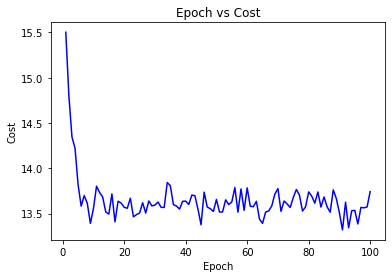

In [19]:
xlim = range(1,len(val2)+1)
plt.plot(xlim,val2,'b')
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Epoch vs Cost")
plt.show()

### two-dimensional visualization

I put one dimension of embedding matrix(Phi) as x-axis,
the other dimension as y-axis

As a result, I could see that it separates really well.

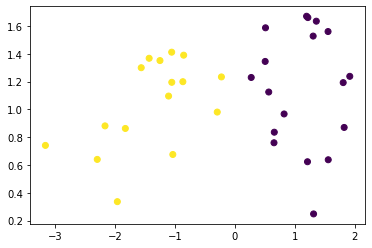

In [20]:
x = model.Phi[:,0] # first dimension of embedding matrix
y = model.Phi[:,1] # second dimension os embedding matrix
plt.scatter(x,y,c= label[:,1])
plt.show()

## comparison with matrix factorization

I copied paste the code of assignment 4

Compared to deepwalk, which classifies well, matrix factorization didn't work well. 
It was good with t-SNE last tiem, but when I draw embedding matrix directly, it looked like it couldn't separate perfectly.


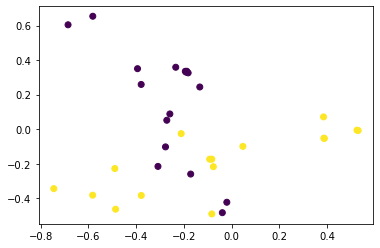

In [21]:
# Define the class for MatrixFactoriztion
class MatrixFactorization():
    
# "Define _init_ to set initial variables. 
    """
    A : adjacency matrix
    epoch : How many epochs
    d : dimension of embedding vector (set default 4, suggested by assignment)
    lr : learning rate (set 0.01 as default, no reason)
    random_state : ranom_state, just to incorporate choice for randomness
    """
    def __init__(self, A,  epoch, d = 4, lr=0.01,random_state = 42):
        self.A = A
        self.d = d
        self.lr = lr
        self.epoch = epoch
        np.random.seed(random_state)
        
        """ 
        self.U and self.V are initial setting for z_u and z_v. 
        I give them random values, made on normal dist.
        """
        self.U = np.random.normal(0,0.03, [A.shape[0], d])
        self.V = self.U.T

        """
        I iterated the matrix by pair of (i,j). 
        So,  convenience later, I made index matrix
        """
        # get length of Adjacency matrix
        index_i = range(A.shape[0]) ;index_j = range(A.shape[0])
        A_index = []
        # Put all paris into index matrix 
        for i in index_i:
            for j in index_j:
                A_index.append((i,j))
        # Randomly shuffle the index to give more randomness
        np.random.shuffle(A_index)
        self.index = A_index
        self.cost = []
        
    """ 
    Iterate over indexes
    calculate z_u * z_v, and calculate the diffrence with real adjacency matrix, 
    do backpropagetion , repeat with (j,i) again
    """    
    def sgd(self):
        cost = []
        for epoch in range(self.epoch):
            for i,j in self.index:
                #propagation
                A_ij_hat = np.dot(self.U[i] , self.V[:,j])
                #calculate gradient
                grad_u = (self.A[i][j] - A_ij_hat) * self.V[:,j]
                grad_v = (self.A[i][j] - A_ij_hat) * self.U[i]
                #backpropagation
                self.U[i]   += self.lr * grad_u
                self.V[:,j] += self.lr * grad_v
            #repeat for (j,i)
                #propagation
                A_ji_hat = np.dot(self.U[i] , self.V[:,j])
                #calculate gradient
                grad_u2 = (self.A[j][i] - A_ij_hat) * self.V[:,i]
                grad_v2 = (self.A[j][i] - A_ij_hat) * self.U[j]
                #backpropagation
                self.U[j]   += self.lr * grad_u2
                self.V[:,i] += self.lr * grad_v2

            #The resulted embedding matrix
            A_hat = np.dot(self.U , self.V)
            # get cost for each epochs
            self.cost.append(np.sum((self.A-A_hat)**2/np.prod(self.A.shape)))
                
#Implemnt the matrixfactorization with 1000 epochs
MF = MatrixFactorization(A = df, epoch = 1000)
MF.sgd()

x = MF.U[:,0]
y = MF.U[:,1]
plt.scatter(x,y,c= label[:,1])
plt.show()